# Fantasy Premier League (FPL) Advisor Neural Network Model Builder

The purpose of this notebook is to train a neural network that can predict the expected points for specific player and fixture combination. Currently, the training data is based on [fpl-data](https://github.com/177arc/fpl-data) which contains a rolling window of fixtures from this and the past season.

# Installation
To get started, run the following command to install all required dependencies.

In [ ]:
#!pip install -q -r requirements.txt
!pip install -q -r requirements_nn.txt

# Import requirements
Here we import all external and local modulues.

In [1]:
import pandas as pd, os, sys
from fplpandas import FPLPandas
from datadict.jupyter import DataDict

import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import matplotlib.pyplot as plt

# Load local modules
sys.path.append(os.getcwd())
from data import get_df
from nn import *

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

# Set variables
This section sets all important global variables.

In [2]:
data_url = 'http://fpl.177arc.net.s3.eu-west-2.amazonaws.com/v1/latest/'

# Load pre-processed data
This section loads data sets generated by the [fpl-data](https://github.com/177arc/fpl-data) lambda function and made available via the S3 bucket specified in the `data_url` variable.

In [3]:
players_fixture_team_eps_ext = get_df(url=f'{data_url}players_gw_team_eps_ext.csv', index=['Player Code', 'Season', 'Game Week'])
players_fixture_team_eps_ext.head(5)

Fixture Total Points  Fixture Minutes Played  \
Player Code Season  Game Week                                                 
6744        2019-20 1                           0.0                     0.0   
                    2                           0.0                     0.0   
                    3                           0.0                     0.0   
                    4                           0.0                     0.0   
                    5                           0.0                     0.0   

                               Fixture Cost  Chance Avail  Fixtures Ago  \
Player Code Season  Game Week                                             
6744        2019-20 1                   5.0           0.0          76.0   
                    2                   5.0           0.0          75.0   
                    3                   5.0           0.0          74.0   
                    4                   4.9           0.0          73.0   
                    5                   4.9           0.0          72.0   

                              Is Home? Fixture Short Name  \
Player Code Season  Game Week                               
6744        2019-20 1             True            MUN-CHE   
                    2            False            WOL-MUN   
                    3             True            MUN-CRY   
                    4            False            SOU-MUN   
                    5             True            MUN-LEI   

                              Fixture Short Name FDR  Team FDR Started  \
Player Code Season  Game Week                                            
6744        2019-20 1                    MUN-CHE (4)       4.0    True   
                    2                    WOL-MUN (3)       3.0    True   
                    3                    MUN-CRY (3)       3.0    True   
                    4                    SOU-MUN (2)       2.0    True   
                    5                    MUN-LEI (3)       3.0    True   

                                     Kick Off Time  Expected Goals For  \
Player Code Season  Game Week                                            
6744        2019-20 1          2019-08-11 15:30:00              0.0000   
                    2          2019-08-19 19:00:00              0.9000   
                    3          2019-08-24 14:00:00              1.0500   
                    4          2019-08-31 11:30:00              1.3000   
                    5          2019-09-14 14:00:00              1.3625   

                               Expected Goals Against  Opp Team Code  \
Player Code Season  Game Week                                          
6744        2019-20 1                        0.000000            8.0   
                    2                        1.600000           39.0   
                    3                        1.300000           31.0   
                    4                        1.233333           20.0   
                    5                        1.262500           13.0   

                               Opp Team FDR  Team Fixture Count Home  \
Player Code Season  Game Week                                          
6744        2019-20 1                   4.0                     11.0   
                    2                   4.0                     11.0   
                    3                   4.0                     11.0   
                    4                   4.0                     11.0   
                    5                   4.0                     11.0   

                               Opp Team Fixture Count Home  \
Player Code Season  Game Week                                
6744        2019-20 1                                 10.0   
                    2                                 11.0   
                    3                                  9.0   
                    4                                 10.0   
                    5                                 10.0   

                               Team Fixt

## Create training and test datasets 

In [4]:
(player_fixture_stats
          [to_fixture_cols]
          .sort_values(['Player Code', 'Kick Off Time'])
          .groupby('Player Code')
          .shift()
          .drop(columns=['Kick Off Time'])
          .merge(player_fixture_stats[non_to_fixture_cols], left_index=True, right_index=True)
          [lambda df: (df['Started'] == True) & (df['Fixture Minutes Played'] > 0)]
          .reset_index())

NameError: name 'player_fixture_stats' is not defined

In [22]:
to_fixture_cols = [col for col in players_fixture_team_eps_ext.columns if 'Recent Fixtures' in col or col == 'Kick Off Time']
non_to_fixture_cols = [col for col in players_fixture_team_eps_ext.columns if 'Recent Fixtures' not in col]

train_df, test_df = (players_fixture_team_eps_ext
      [to_fixture_cols]
      .sort_values(['Player Code', 'Kick Off Time'])
      .groupby('Player Code')
      .shift()
      .drop(columns=['Kick Off Time'])
      .merge(players_fixture_team_eps_ext[non_to_fixture_cols], left_index=True, right_index=True)
    .reset_index()
    [lambda df: df['Fixture Minutes Played'] > 0]
    .assign(**{'Is Home?': lambda df: df['Is Home?'].astype(int)})
#[['Fixture Total Points']].assign(**{'Total Points': lambda df: df['Fixture Total Points']})
#[['Fixture Total Points', 'Player Code']]
#[['Fixture Total Points', 'Field Position', 'Total Points Recent Fixtures', 'Fixtures Played Recent Fixtures', 'Opp Team FDR']]
#'ICT Index Recent Fixtures', 'Influence Recent Fixtures', 'Creativity Recent Fixtures',
[lambda df: df['Field Position'].isin(['MID', 'FWD'])]
# [['Fixture Total Points',  'Threat Recent Fixtures', 'Total Points Recent Fixtures', 'Fixtures Played Recent Fixtures', 'Rel Att Fixture Strength']]
[['Fixture Total Points', 'Avg Threat Recent Fixtures', 'Expected Points']]
    .dropna(how='any', axis=0)
    .pipe(nn_split, frac=0.8))
train_ds = train_df.pipe(nn_prep_ds, 'Fixture Total Points')
test_ds = test_df.pipe(nn_prep_ds, 'Fixture Total Points')

## Create feature columns

In [21]:
feature_columns_cats = {'field_position': ['GK', 'DEF', 'MID', 'FWD']}

feature_columns = []
for col, spec in train_ds.element_spec[0].items():
    if spec.dtype in [tf.bool, tf.float64]:
        feature_columns.append(feature_column.numeric_column(col))
        
    if col in feature_columns_cats.keys():
        field_pos = feature_column.categorical_column_with_vocabulary_list(col, feature_columns_cats[col])
        field_pos_one_hot = feature_column.indicator_column(field_pos)
        feature_columns.append(field_pos_one_hot)        

## Create model
Here we create a neural network with four layers. Although ultimately the mean 

In [16]:
model = tf.keras.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns, dtype='float64'),
  layers.Dense(5, activation='relu', dtype='float64'),
  layers.Dense(3, activation='relu', dtype='float64'),
  layers.Dense(1, dtype='float64')
])

model.compile(loss='msle',
                optimizer=tf.keras.optimizers.RMSprop(0.001),
                metrics=['mse', 'mae', 'msle'])

## Train model

In [17]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

train_history = model.fit(train_ds,
          validation_data=test_ds,
          epochs=60,
          callbacks=[early_stop])

Epoch 1/60
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
187/209 [=========================>....] - ETA: 0s - loss: 0.9005 - mse: 15.1565 - mae: 2.4873 - msle: 0.9005WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'expected_points': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>}
Consider rewriting this model with the Functional API.
209/209 [==============================] - 0s 2ms/step - loss: 0.8600 - mse: 14.8386 - mae: 2.4304 - msle: 0.8600 - val_loss: 0.4730 - val_mse: 11.9692 - val_mae: 1.9729 - val_msle: 0.4730
Epoch 2/60
209/209 [==============================] - 0s 967us/step - loss: 0.3931 - mse: 10.9393 - mae: 1.9413 - msle: 0.3931 - val_loss: 0.3086 - val_mse: 9.5192 - val_mae: 1.7954 - val_msle: 0.3086
Epoch 3/60
209/209 [==============================] - 0s 974us/step - loss: 0.3242 - mse: 9.6370 - mae: 1.8656 - msle: 0

209/209 [==============================] - 0s 976us/step - loss: 0.3085 - mse: 9.3711 - mae: 1.8532 - msle: 0.3085 - val_loss: 0.2866 - val_mse: 9.1952 - val_mae: 1.7679 - val_msle: 0.2866
Epoch 38/60
209/209 [==============================] - 0s 957us/step - loss: 0.3085 - mse: 9.3704 - mae: 1.8533 - msle: 0.3085 - val_loss: 0.2866 - val_mse: 9.1950 - val_mae: 1.7679 - val_msle: 0.2866
Epoch 39/60
209/209 [==============================] - 0s 1ms/step - loss: 0.3084 - mse: 9.3702 - mae: 1.8533 - msle: 0.3084 - val_loss: 0.2866 - val_mse: 9.1958 - val_mae: 1.7678 - val_msle: 0.2866
Epoch 40/60
209/209 [==============================] - 0s 1ms/step - loss: 0.3084 - mse: 9.3702 - mae: 1.8533 - msle: 0.3084 - val_loss: 0.2866 - val_mse: 9.1964 - val_mae: 1.7678 - val_msle: 0.2866
Epoch 41/60
209/209 [==============================] - 0s 1ms/step - loss: 0.3084 - mse: 9.3702 - mae: 1.8533 - msle: 0.3084 - val_loss: 0.2866 - val_mse: 9.1966 - val_mae: 1.7678 - val_msle: 0.2866
Epoch 42/60
2

## Evaluate model

Text(0,0.5,'MAE [Fixture]')

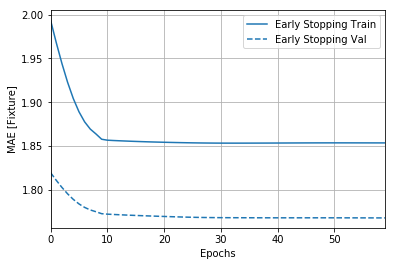

In [23]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': train_history}, metric = 'mae')
plt.ylabel('MAE [Fixture]')

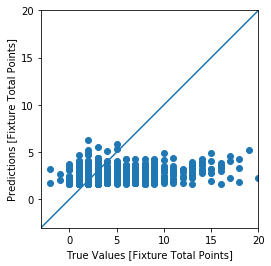

In [24]:
test_predictions = model.predict(test_ds).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_df['Fixture Total Points'], test_predictions)
plt.xlabel('True Values [Fixture Total Points]')
plt.ylabel('Predictions [Fixture Total Points]')
lims = [-3, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [225]:
test_df['Predicted'] = test_predictions
test_df

,Fixture Total Points,Threat Recent Fixtures,Expected Points,Predicted
846,1.0,47.0,1.669856,1.870928
20309,2.0,163.0,1.300000,2.042605
7199,2.0,312.0,2.652867,2.680054
9969,2.0,420.0,5.122892,3.540725
39944,2.0,56.0,1.993382,1.991858
...,...,...,...,...
35677,1.0,311.0,5.007868,3.318412
5412,2.0,77.0,2.736011,2.215592
36744,1.0,0.0,1.000000,1.596552
15177,2.0,191.0,2.243866,2.206420


## Save model

In [ ]:
model.save('models/expected_points')